In [38]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

In [2]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [39]:
def define_model2(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(Dropout(0.2))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(tar_vocab, activation='softmax'))
    return model

In [ ]:
# load datasets

dataset = load_clean_sentences('english-hindi_training.pkl')

In [14]:
train, validation = dataset[:2000], dataset[2000:]

In [45]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(array(dataset)[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(array(dataset)[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare porutguese tokenizer
hin_tokenizer = create_tokenizer(array(dataset)[:, 1])
hin_vocab_size = len(hin_tokenizer.word_index) + 1
hin_length = max_length(array(dataset)[:, 1])
print('Hindi Vocabulary Size: %d' % hin_vocab_size)
print('Hindi Max Length: %d' % (hin_length))
 
# prepare training data
trainY = encode_sequences(hin_tokenizer, hin_length, array(train)[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, array(train)[:, 0])
#trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
validationY = encode_sequences(hin_tokenizer, hin_length, array(validation)[:, 1])
validationX = encode_sequences(eng_tokenizer, eng_length, array(validation)[:, 0])
#validationY = encode_output(validationY, eng_vocab_size)
 
# define model
#model2 = define_model2(hin_vocab_size, eng_vocab_size, hin_length, eng_length, 256)
model2 = define_model2(eng_vocab_size, hin_vocab_size, eng_length, hin_length, 256)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# summarize defined model
print(model2.summary())
plot_model(model2, to_file='model.png', show_shapes=True)

English Vocabulary Size: 2362
English Max Length: 22
Hindi Vocabulary Size: 2996
Hindi Max Length: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 22, 256)           604672    
_________________________________________________________________
lstm_18 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 25, 256)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 25, 256)           525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 25, 256)           0         
________________________________________

In [23]:
validation[10:30]

[['he will get better little by little', 'वह धीरे-धीरे ठीक हो जाएगा।'],
 ['her advice to me was to work harder',
  'उसकी मेरे लिए सलाह यह थी कि मैं ज़्यादा मन लगाकर काम करूँ।'],
 ['her way of talking got on my nerves',
  'उसके बात करने के तरीके पर मुझे खींज आती है।'],
 ['hurry and you will catch the train', 'जल्दी करो तो ट्रेन पकड़ सकते हो।'],
 ['i am a student at oxford university',
  'मैं ऑक्सफ़र्ड विश्वविद्यालय में विद्यार्थी हूँ।'],
 ['i am really pleased with my new car', 'मैं अपनी नई गाड़ी से बहुत खुश हूँ।'],
 ['i buried my dog at the pet cemetery',
  'मैंने अपने कुत्ते को पालतू जानवरों के कब्रिस्तान में बरी कर दिया।'],
 ['i dont want to spend more than ',
  'मैं दस डॉलर से ज़्यादा नहीं खर्चना चाह्ता हूँ।'],
 ['i never dreamed that you would lose',
  'मैंने सपने में भी नहीं सोचा था कि तुम हार जाओगे।'],
 ['i visit my grandmother twice a week',
  'मैं अपनी नानी से हफ़्ते में दो बार मिलने जाता हूँ।'],
 ['i visit my grandmother twice a week',
  'मैं अपनी दादी से हफ़्ते में दो बार मिल

In [46]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
fit2 = model2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=50, batch_size=64, validation_data=(validationX, validationY.reshape(validationY.shape[0], validationY.shape[1], 1)), callbacks=[checkpoint], verbose=2)

Train on 2000 samples, validate on 831 samples
Epoch 1/50
 - 16s - loss: 4.1116 - val_loss: 3.5235

Epoch 00001: val_loss improved from inf to 3.52349, saving model to model.h5
Epoch 2/50
 - 14s - loss: 1.8913 - val_loss: 2.8537

Epoch 00002: val_loss improved from 3.52349 to 2.85369, saving model to model.h5
Epoch 3/50
 - 14s - loss: 1.6853 - val_loss: 2.9806

Epoch 00003: val_loss did not improve from 2.85369
Epoch 4/50
 - 13s - loss: 1.6217 - val_loss: 2.8557

Epoch 00004: val_loss did not improve from 2.85369
Epoch 5/50
 - 13s - loss: 1.5882 - val_loss: 2.8355

Epoch 00005: val_loss improved from 2.85369 to 2.83554, saving model to model.h5
Epoch 6/50
 - 12s - loss: 1.5576 - val_loss: 2.8673

Epoch 00006: val_loss did not improve from 2.83554
Epoch 7/50
 - 12s - loss: 1.5192 - val_loss: 2.8525

Epoch 00007: val_loss did not improve from 2.83554
Epoch 8/50
 - 12s - loss: 1.5024 - val_loss: 2.9368

Epoch 00008: val_loss did not improve from 2.83554
Epoch 9/50
 - 12s - loss: 1.4845 - 

In [42]:
validationY.shape

(831, 22)

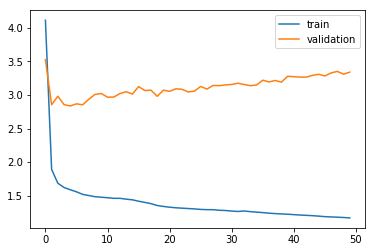

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fit2.history['loss'])
plt.plot(fit2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()